# Convolutional Neural Network

In this second exercise-notebook we will play with Convolutional Neural Network (CNN). 

As you should have seen, a CNN is a feed-forward neural network tipically composed of Convolutional, MaxPooling and Dense layers. 

If the task implemented by the CNN is a classification task, the last Dense layer should use the **Softmax** activation, and the loss should be the **categorical crossentropy**.

Reference: [https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py]()

## Network Topology Model

A simple CNN, with one input branch and one output branch can be defined using a [Sequential](http://keras.io/models/#sequential) model and stacking together all its layers. 

In this exercise we want to build a (_quite shallow_) network which contains two 
[Convolution, Convolution, MaxPooling] stages, and two Dense layers.

To test a different optimizer, we will use [AdaDelta](http://keras.io/optimizers/), which is a bit more complex than the simple Vanilla SGD with momentum.

In [8]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adadelta
from keras.optimizers import SGD
from keras.layers.normalization import BatchNormalization


In [3]:

input_shape = (3, 32, 32)
nb_classes = 10


nb_epoch = 10 # kept very low! Please increase if you have GPU

batch_size = 64
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

## [conv@32x3x3+relu]x2 --> MaxPool@2x2 --> DropOut@0.25 -->
## [conv@64x3x3+relu]x2 --> MaxPool@2x2 --> DropOut@0.25 -->
## Flatten--> FC@512+relu --> DropOut@0.5 --> FC@nb_classes+SoftMax
## NOTE: each couple of Conv filters must have `border_mode="same"` and `"valid"`, respectively

## your code here



In [31]:
img_rows, img_cols = 32, 32
shape_ord = (img_rows, img_cols, 3)
nb_filters_small = 4
nb_pool_small = 4
model = Sequential()

model.add(Conv2D(nb_filters_small, (nb_conv, nb_conv), padding='valid', 
                 input_shape=shape_ord))  # note: the very first layer **must** always specify the input_shape

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool_small, nb_pool_small)))

model.add(Flatten())
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [32]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
# %load solutions/sol_223.py

In [ ]:
nb_filters_small = 4
nb_pool_small = 4
model = Sequential()

model.add(Conv2D(nb_filters_small, (32, 32), padding='valid', 
                 input_shape=shape_ord))  # note: the very first layer **must** always specify the input_shape

# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool_small, nb_pool_small)))
model.add(Dropout(0.5))
model.add(Conv2D(nb_filters_small, (64, 64), padding='valid', 
                 input_shape=shape_ord))  # note: the very first layer **must** always specify the input_shape

# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool_small, nb_pool_small)))

model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

### Understanding layer shapes

An important feature of Keras layers is that each of them has an `input_shape` attribute, which you can use to visualize the shape of the input tensor, and an `output_shape` attribute, for inspecting the shape of the output tensor.

As we can see, the input shape of the first convolutional layer corresponds to the `input_shape` attribute (which must be specified by the user). 

In this case, it is a `32x32` image with three color channels. 

Since this convolutional layer has the `border_mode` set to `same`, its output width and height will remain the same, and the number of output channel will be equal to the number of filters learned by the layer, 16. 

The following convolutional layers, instead, have the default `border_mode`, and therefore reduce width and height by $(k-1)$, where $k$ is the size of the kernel. 

MaxPooling layers, instead, reduce width and height of the input tensor, but keep the same number of channels. Activation layers, of course, don't change the shape.

In [6]:
for i, layer in enumerate(model.layers):
    print "Layer", i, "\t", layer.input_shape, "\t", layer.output_shape

Layer 0 	(None, 32, 32, 3) 	(None, 30, 30, 4)
Layer 1 	(None, 30, 30, 4) 	(None, 30, 30, 4)
Layer 2 	(None, 30, 30, 4) 	(None, 30, 30, 4)
Layer 3 	(None, 30, 30, 4) 	(None, 7, 7, 4)
Layer 4 	(None, 7, 7, 4) 	(None, 196)
Layer 5 	(None, 196) 	(None, 10)
Layer 6 	(None, 10) 	(None, 10)


### Understanding weights shape
In the same way, we can visualize the shape of the weights learned by each layer. In particular, Keras lets you inspect weights by using the `get_weights` method of a layer object. This will return a list with two elements, the first one being the weight tensor and the second one being the bias vector.

Of course, MaxPooling layer don't have any weight tensor, since they don't have learnable parameters. Convolutional layers, instead, learn a $(n_o, n_i, k, k)$ or **$(k, k, n_i, n_o)$** weight tensor, where $k$ is the size of the kernel, $n_i$ is the number of channels of the input tensor, and $n_o$ is the number of filters to be learned. For each of the $n_o$ filters, a bias is also learned. Dense layers learn a $(n_i, n_o)$ weight tensor, where $n_o$ is the output size and $n_i$ is the input size of the layer. Each of the $n_o$ neurons also has a bias.

In [12]:
for i, layer in enumerate(model.layers):
    if len(layer.get_weights()) > 0:
        print("Layer", i, "\t", layer.get_weights()[0].shape, "\t", layer.get_weights()[1].shape)

Layer 0 	 (3, 3, 5, 4) 	 (4,)
Layer 1 	 (4,) 	 (4,)
Layer 5 	 (196, 10) 	 (10,)


In [15]:
from keras import backend as K
K.image_data_format()

'channels_last'

# Training the network

We will train our network on the **CIFAR10** [dataset](https://www.cs.toronto.edu/~kriz/cifar.html), which contains `50,000` 32x32 color training images, labeled over 10 categories, and 10,000 test images. 

As this dataset is also included in Keras datasets, we just ask the `keras.datasets` module for the dataset.

Training and test images are normalized to lie in the $\left[0,1\right]$ interval.

In [33]:
from keras.datasets import cifar10
from keras.utils import np_utils

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

In [ ]:
hist = model.fit(X_train, Y_train, batch_size=batch_size, 
                 epochs=nb_epoch, verbose=1, 
                 validation_data=(X_test, Y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 14s - loss: 2.0459 - acc: 0.2716 - val_loss: 1.8912 - val_acc: 0.3144
Epoch 2/10
50000/50000 [==============================] - 15s - loss: 1.8171 - acc: 0.3512 - val_loss: 1.7448 - val_acc: 0.3813
Epoch 3/10
50000/50000 [==============================] - 16s - loss: 1.7001 - acc: 0.3941 - val_loss: 1.9825 - val_acc: 0.3446
Epoch 4/10
50000/50000 [==============================] - 18s - loss: 1.6213 - acc: 0.4221 - val_loss: 1.6490 - val_acc: 0.4209
Epoch 5/10
50000/50000 [==============================] - 18s - loss: 1.5641 - acc: 0.4433 - val_loss: 1.7495 - val_acc: 0.4012
Epoch 6/10
50000/50000 [==============================] - 19s - loss: 1.5251 - acc: 0.4567 - val_loss: 1.6340 - val_acc: 0.4336
Epoch 7/10
50000/50000 [==============================] - 19s - loss: 1.5006 - acc: 0.4684 - val_loss: 1.6388 - val_acc: 0.4191
Epoch 8/10
50000/50000 [==============================

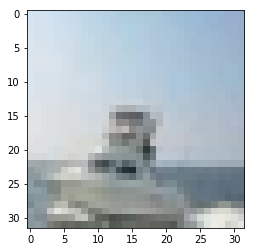

In [29]:
% matplotlib inline
from matplotlib import pyplot as plt
imgplot = plt.imshow(X_train[100])

In [16]:
X_train.shape

(50000, 32, 32, 3)

To reduce the risk of overfitting, we also apply some image transformation, like rotations, shifts and flips. All these can be easily implemented using the Keras [Image Data Generator](http://keras.io/preprocessing/image/).

#### Warning: The following cells may be computational Intensive....

In [7]:
from keras.preprocessing.image import ImageDataGenerator

generated_images = ImageDataGenerator(
    featurewise_center=True,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=True,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images

generated_images.fit(X_train)

Now we can start training. 

At each iteration, a batch of 500 images is requested to the `ImageDataGenerator` object, and then fed to the network.

In [10]:
X_train.shape

(50000, 3, 32, 32)

In [11]:
gen = generated_images.flow(X_train, Y_train, batch_size=500, shuffle=True)
X_batch, Y_batch = next(gen)

In [12]:
X_batch.shape

(500, 3, 32, 32)

In [ ]:
from keras.utils import generic_utils

n_epochs = 2
for e in range(n_epochs):
    print('Epoch', e)
    print('Training...')
    progbar = generic_utils.Progbar(X_train.shape[0])
    
    for X_batch, Y_batch in generated_images.flow(X_train, Y_train, batch_size=500, shuffle=True):
        loss = model.train_on_batch(X_batch, Y_batch)
        progbar.add(X_batch.shape[0], values=[('train loss', loss[0])])